In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization
from keras.models import Model
from keras.models import model_from_yaml
import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import pandas as pd

np.random.seed(5)
from tensorflow import set_random_seed
set_random_seed(12)


Using TensorFlow backend.


In [2]:
# plotting

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def confusion_plot(y_true_labels, y_pred_labels, title, class_names): 

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("All data confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title=title)

    plt.show()
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=title)

    plt.show()

In [3]:
def cnn_model(X_train, X_test, y_train, y_test):

    # X_train, y_train = load_data()

    inputs = Input(shape=(1, 23, 4), name='main_input')
    conv_1 = Conv2D(10, (1, 1), padding='same', activation='relu')(inputs)
    conv_2 = Conv2D(10, (1, 2), padding='same', activation='relu')(inputs)
    conv_3 = Conv2D(10, (1, 3), padding='same', activation='relu')(inputs)
    conv_4 = Conv2D(10, (1, 5), padding='same', activation='relu')(inputs)

    conv_output = keras.layers.concatenate([conv_1, conv_2, conv_3, conv_4])

    bn_output = BatchNormalization()(conv_output)

    pooling_output = keras.layers.MaxPool2D(pool_size=(1, 5), strides=None, padding='valid')(bn_output)

    flatten_output = Flatten()(pooling_output)

    x = Dense(100, activation='relu')(flatten_output)
    x = Dense(23, activation='relu')(x)
    x = keras.layers.Dropout(rate=0.15)(x)

    prediction = Dense(2, name='main_output')(x)

    model = Model(inputs, prediction)

    adam_opt = keras.optimizers.adam(lr = 0.0001)

    model.compile(loss='binary_crossentropy', optimizer = adam_opt)
    print(model.summary())
    model.fit(X_train, y_train, batch_size=100, epochs=200, shuffle=True)

    # later...
    # X_test, y_test = load_crispor_data()
    y_pred = model.predict(X_test).flatten()

In [4]:
# moved outside of function to only load model once!!
# load YAML and create model
yaml_file = open('../CNN_std_model/model_cnn_v1.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("../CNN_std_model/model_cnn_v1.h5")
#print("Loaded model from disk")

def cnn_predict(guide_seq, off_seq):

    code_dict = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    gRNA_list = list(guide_seq)
    off_list = list(off_seq)
    #print(len(gRNA_list))
    if len(gRNA_list) != len(off_list):
        #print("the length of sgRNA and DNA are not matched!")
        return 0
    pair_code = []

    for i in range(len(gRNA_list)):
        if gRNA_list[i] == 'N':
            gRNA_list[i] = off_list[i]
        gRNA_base_code = code_dict[gRNA_list[i]]
        DNA_based_code = code_dict[off_list[i]]
        pair_code.append(list(np.bitwise_or(gRNA_base_code, DNA_based_code)))
    input_code = np.array(pair_code).reshape(1, 1, 23, 4)

#     # load YAML and create model
#     yaml_file = open('../CNN_std_model/model_cnn_v1.yaml', 'r')
#     loaded_model_yaml = yaml_file.read()
#     yaml_file.close()
#     loaded_model = model_from_yaml(loaded_model_yaml)
#     # load weights into new model
#     loaded_model.load_weights("../CNN_std_model/model_cnn_v1.h5")
#     #print("Loaded model from disk")

    y_pred = loaded_model.predict(input_code).flatten()
    #print(y_pred)
    return y_pred, input_code

In [5]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

# read in train, val, test dfs 
data_dir = '../data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [10]:
results = cnn_predict(test_df['On-Target Site'][100], test_df['Off-Target Site'][100])
print(results[1].shape)

(1, 1, 23, 4)


In [13]:
tp = 0
tn = 0
fp = 0
fn = 0
y_pred = []
y_pred_labels = []
y_true = test_bins
y_true_labels = np.argmax(y_true, axis=1)
input_codes = []
for guide,ot, score in zip(test_df['On-Target Site'], test_df['Off-Target Site'], y_true_labels): 
    results = cnn_predict(guide,ot)
    pred = results[0][0]
    inp_code = results[1]
    y_pred.append(pred)
    if pred >= 0.5: 
        y_pred_labels.append(1)
        if score == 1: tp += 1
        else: fp += 1
    else:
        y_pred_labels.append(0)
        if score == 1: fn += 1
        else: tn += 1
    input_codes.append(inp_code)
total_samples = len(test_df)
print('precision:', tp/(tp+fp))
print('recall:', tp/(fn+tp))

precision: 0.46264367816091956
recall: 0.9470588235294117


In [14]:
print('accuracy:', (tp + tn)/(tp+fp+tn+fn))

accuracy: 0.9976075386943997


AUC: 0.9723857368374852
Average precision-recall score: 0.48


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.48')

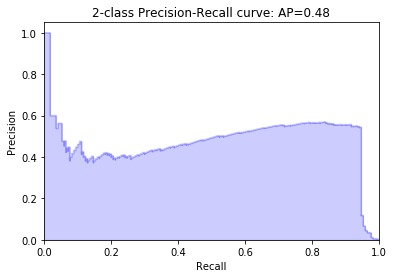

In [15]:
# from TAs on piazza: use precision-recall, ROC can be misleading 
# modified code from sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# and referenced: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

from sklearn.metrics import roc_auc_score

print('AUC:', roc_auc_score(y_true_labels, y_pred_labels))

#y_pred += 1
#y_true_labels = abs(y_true_labels - 1)
average_precision = average_precision_score(y_true_labels,y_pred)#(y_true, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_true_labels, y_pred) # look at positive class prob

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [16]:
from sklearn.metrics import f1_score
print('F1:', f1_score(y_true_labels,y_pred_labels, average='macro'),'\n')

F1: 0.8102107985656629 



In [17]:
from sklearn.metrics import confusion_matrix
#y_true = abs(y_true_labels - 1)
confusion_matrix(y_true_labels, y_pred_labels)

array([[81567,   187],
       [    9,   161]])

Confusion matrix, without normalization
[[81567   187]
 [    9   161]]


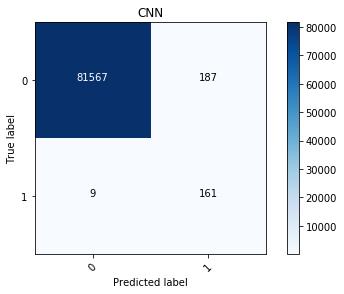

All data confusion matrix
[[1.   0.  ]
 [0.05 0.95]]


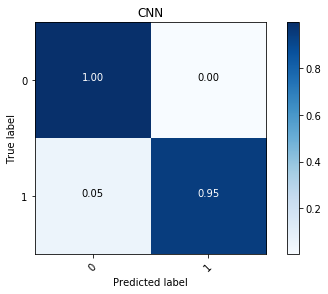

In [18]:
confusion_plot(y_true_labels, y_pred_labels,'CNN', ['0','1'])